In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import glob
from scipy.misc import imsave
import matplotlib.mlab as mlab
from moviepy.editor import *

In [2]:
from basic_lane_lines import weighted_img, find_lane3
from util import *

In [3]:
data_dir = 'data'

# Calibrate Camera

In [4]:
camera_cal_dir = 'camera_cal'

In [5]:
def load_camera_cal_images(camera_cal_dir):
    img_files = glob.glob('%s/*.jpg' % camera_cal_dir)
    return [imread(img_file) for img_file in img_files], img_files

In [6]:
camera_cal_img_arr, camera_cal_img_files = load_camera_cal_images(camera_cal_dir)

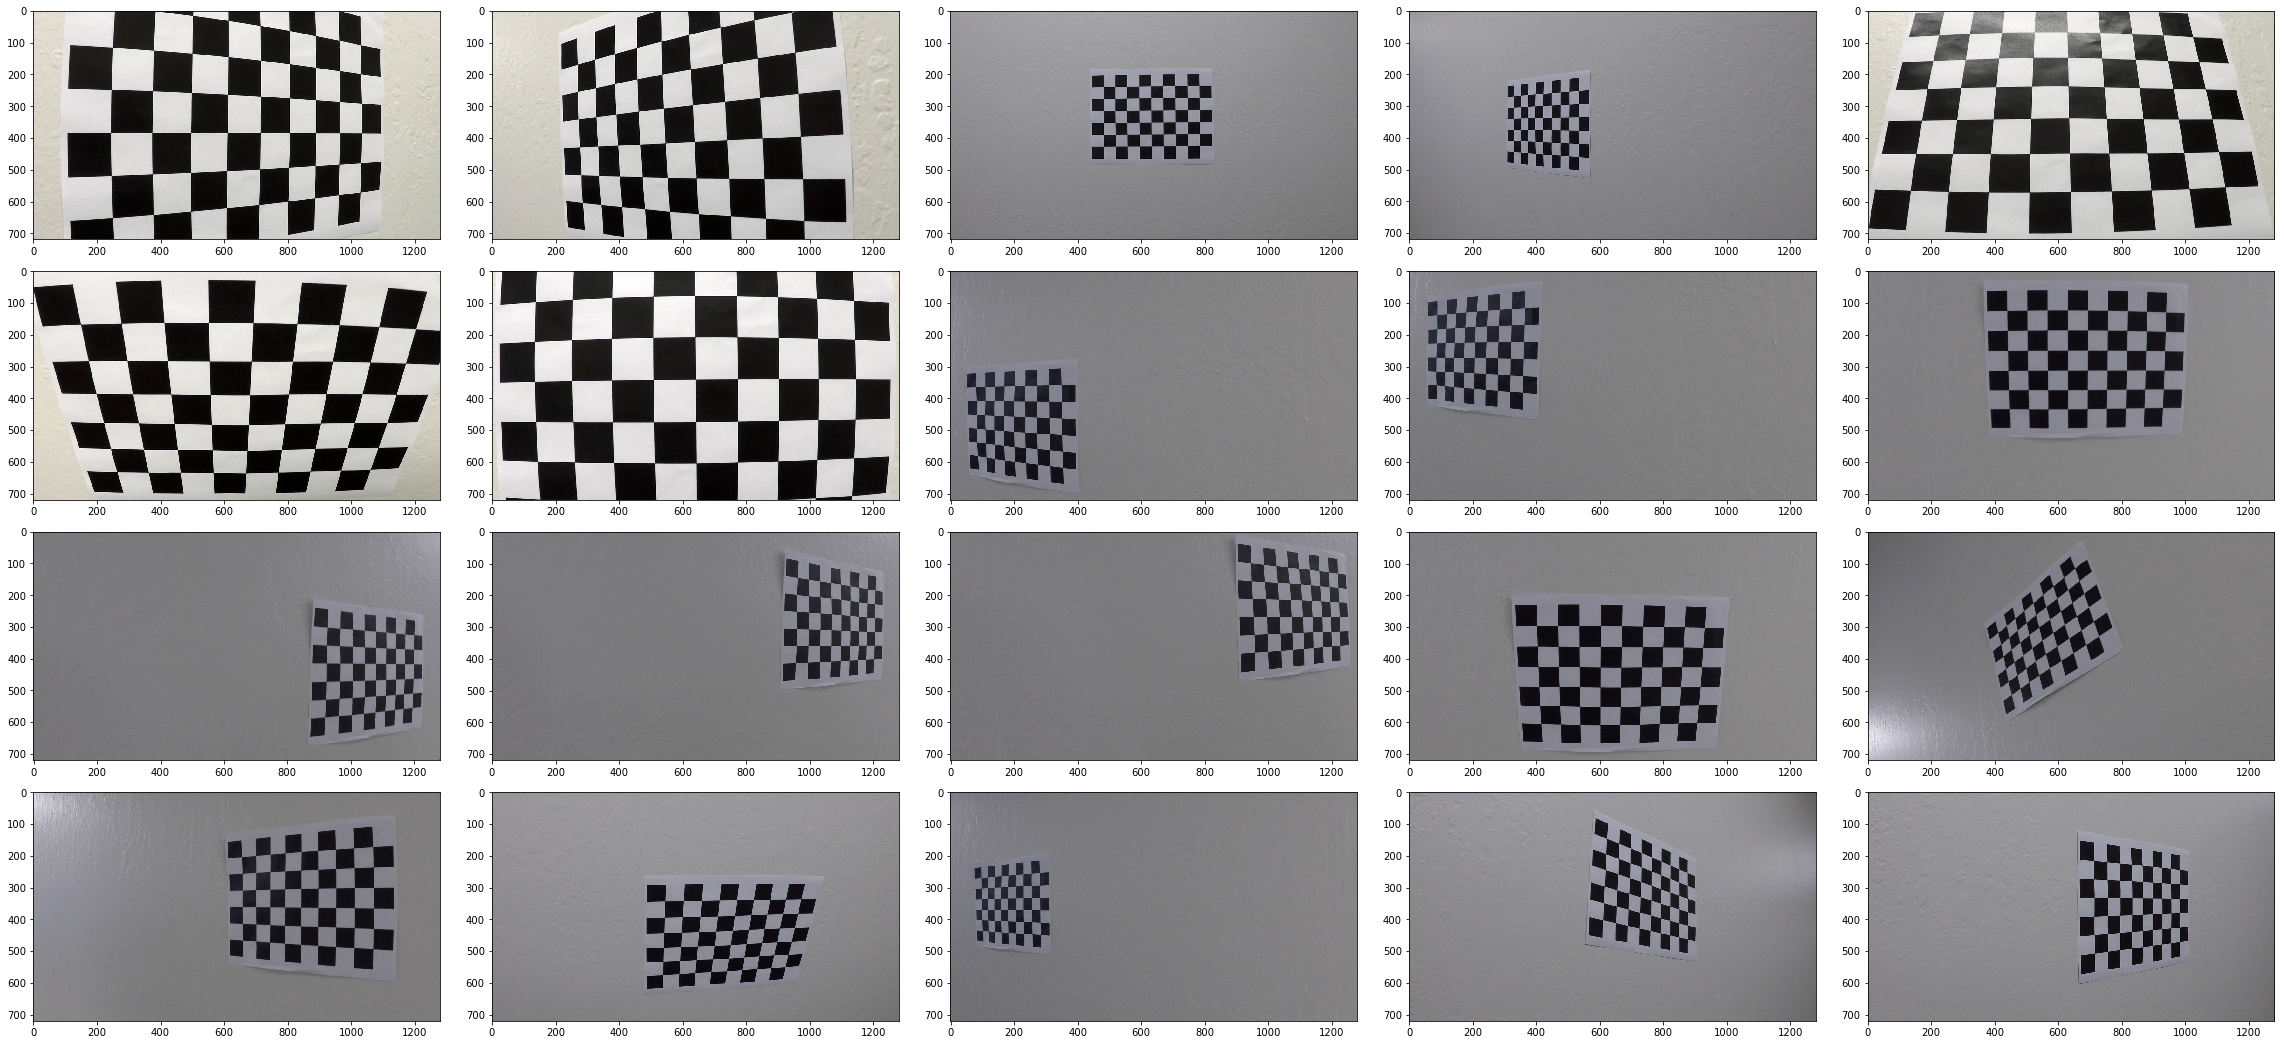

In [7]:
display_images(camera_cal_img_arr)

Save an image for testing.

In [8]:
test_img = camera_cal_img_arr[6]
camera_cal_img_arr = [camera_cal_img_arr[i] for i in range(len(camera_cal_img_arr)) if i != 6]
camera_cal_img_files = [camera_cal_img_files [i] for i in range(len(camera_cal_img_files)) if i != 6]

The objpoints and imgpoints will be used for unwarping video frames later .

In [9]:
objpoints = []
imgpoints = []

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
for img in tqdm(camera_cal_img_arr):
    x_cnt = 9
    y_cnt = 6

    objp = np.zeros((y_cnt*x_cnt,3), np.float32)
    objp[:,:2] = np.mgrid[0:x_cnt,0:y_cnt].T.reshape(-1,2)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (y_cnt, x_cnt), None)

    if ret:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)   
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


100%|██████████| 19/19 [00:02<00:00,  6.78it/s]


In [10]:
def cal_undistort(img, objpoints, imgpoints):    
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
                                                        gray.shape[::-1], 
                                                        None, None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist

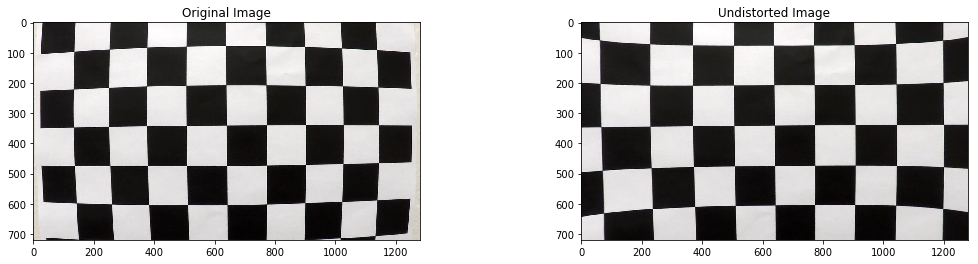

In [11]:
undistorted_img = cal_undistort(test_img, objpoints, imgpoints)

plt.figure(figsize=(18,4))

ax = plt.subplot(1,2,1)
ax.set_title('Original Image')
plt.imshow(test_img)
ax = plt.subplot(1,2,2)
ax.set_title('Undistorted Image')
plt.imshow(undistorted_img)
plt.show()

The original test image and the undistorted image using cal_undistort() are shown above.

## Undistorting Video Frames

In [12]:
def load_test_images(test_img_dir):
    img_files = glob.glob('%s/*.jpg' % test_img_dir)
    return [imread(img_file) for img_file in img_files], img_files

In [13]:
test_image_arr, test_img_files = load_test_images('test_images')

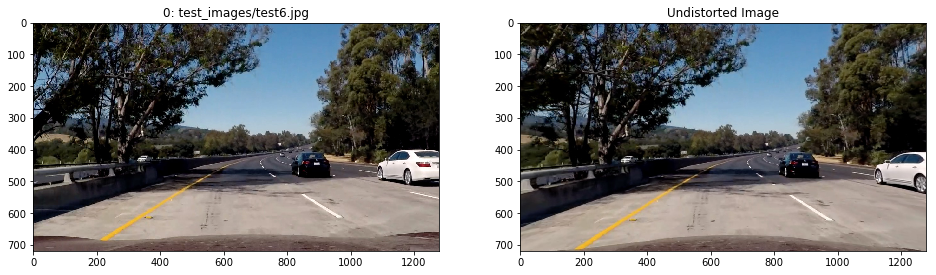

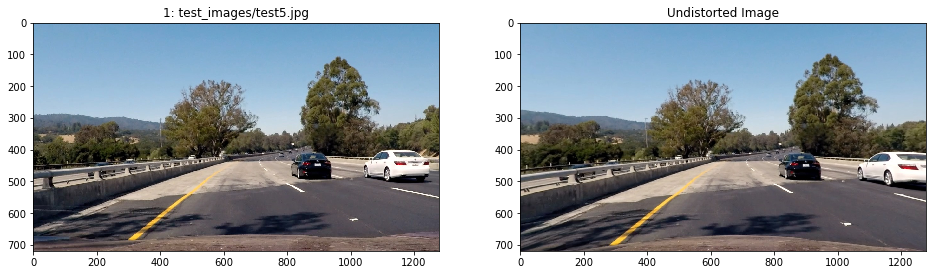

In [14]:
for i,img in enumerate(test_image_arr[1:3]):
    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    
    plt.figure(figsize=(16,16))
    
    ax = plt.subplot(1,2,1)
    ax.set_title("%d: %s" % (i, test_img_files[i]))
    plt.imshow(img)
    ax = plt.subplot(1,2,2)
    ax.set_title('Undistorted Image')
    plt.imshow(undistorted_img)
    plt.show()

Here are some test images with cal_undistort() applied to them.  Two noticeable differences with the undistorted images are:

1. The dashboard on the bottom right has a similar curvature to the bottom left.
2. The white dashed lane lines on the right have a smoother curve.

## Binary Image

For finding the lane line, we will create a binary image from the original image using various threshold methods.

## HLS Thresholds

The images will be converted from RGB to HLS.  Only thresholds from the saturation and hue layers will be used.

In [15]:
def make_S_threshold_img(img, thresh = (90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]

    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

def make_H_threshold_img(img, thresh = (15, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]

    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1

    return binary

def make_SH_threshold_img(img, S_thresh = (90, 255), H_thresh = (15, 100)):
    S_threshold_img = make_S_threshold_img(img, thresh = S_thresh)
    H_threshold_img = make_H_threshold_img(img, thresh = H_thresh)
    
    combined_thresholds_img = np.logical_and(S_threshold_img, H_threshold_img)
    
    return 255*combined_thresholds_img.astype(np.uint8)

In [16]:
test_img = test_image_arr[0]

In [17]:
test_S_threshold_img = make_S_threshold_img(img, thresh = (90, 255))
test_H_threshold_img = make_H_threshold_img(img, thresh = (15, 100))
test_SH_threshold_img = make_SH_threshold_img(img, S_thresh = (90, 255), H_thresh = (15, 100))

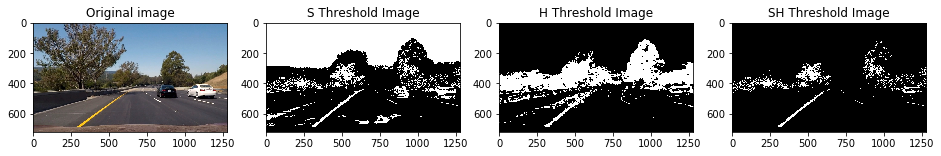

In [18]:
plt.figure(figsize=(16,16))
    
ax = plt.subplot(1,4,1)
ax.set_title('Original image')
plt.imshow(test_img)
ax = plt.subplot(1,4,2)
ax.set_title('S Threshold Image')
plt.imshow(test_S_threshold_img, cmap='gray')
ax = plt.subplot(1,4,3)
ax.set_title('H Threshold Image')
plt.imshow(test_H_threshold_img, cmap='gray')
ax = plt.subplot(1,4,4)
ax.set_title('SH Threshold Image')
plt.imshow(test_SH_threshold_img, cmap='gray')
plt.show()

Above is a comparison of the original image, the saturation and hue threshold images and the saturation and hue combined (logical AND).  The combination of saturation and hue has less noise compared to either of them separately.

## Gradient Thresholds

In [19]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [20]:
abs_sobel_thresh_x_sample_video_img = abs_sobel_thresh(test_img, orient='x', thresh_min=20, thresh_max=100)
abs_sobel_thresh_y_sample_video_img = abs_sobel_thresh(test_img, orient='y', thresh_min=20, thresh_max=100)

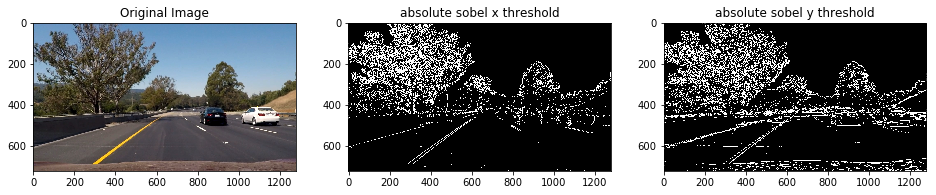

In [21]:
i = 1
cols = 3
rows = 1

plt.figure(figsize=(16,16))

ax = plt.subplot(rows,cols,i)
ax.set_title('Original Image')
plt.imshow(test_img, cmap='gray')

i += 1
ax = plt.subplot(rows,cols,i)
ax.set_title('absolute sobel x threshold')
plt.imshow(abs_sobel_thresh_x_sample_video_img, cmap='gray')

i += 1
ax = plt.subplot(rows,cols,i)
ax.set_title('absolute sobel y threshold')
plt.imshow(abs_sobel_thresh_y_sample_video_img, cmap='gray')

plt.show()

Here the Sobel filter is being used to find gradient thresholds in the x and y directions.

In [22]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [23]:
mag_thresh_sample_video_img = mag_thresh(test_img, mag_thresh=(30, 100))

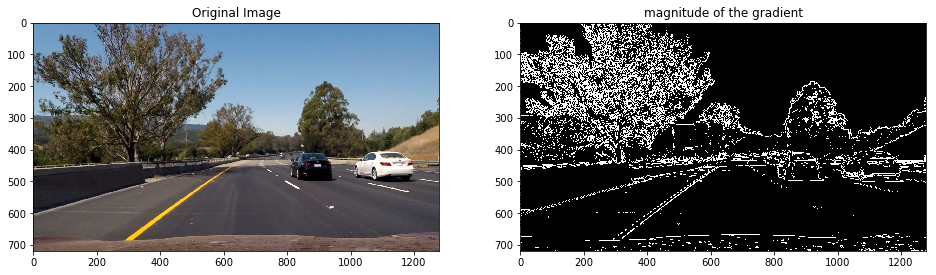

In [24]:
plt.figure(figsize=(16,16))

ax = plt.subplot(1,2,1)
ax.set_title('Original Image')
plt.imshow(test_img, cmap='gray')

ax = plt.subplot(1,2,2)
ax.set_title('magnitude of the gradient')
plt.imshow(mag_thresh_sample_video_img, cmap='gray')

plt.show()

Using the x and Sobel gradients, we can also calculate the magnitude of the gradients.

## Combined Thresholds

In [139]:
def combine_thresholds(abs_sobel_x_thresh_img, abs_sobel_y_thresh_img, 
                      mag_thresh_img, SH_threshold_img):    
    combined_thresholds_img = np.logical_or(abs_sobel_x_thresh_img, abs_sobel_y_thresh_img)
    combined_thresholds_img = np.logical_or(combined_thresholds_img, mag_thresh_img)
    combined_thresholds_img = np.logical_or(combined_thresholds_img, SH_threshold_img)
    
    return 255*combined_thresholds_img.astype(np.uint8)

In [111]:
combine_thresholds_sample_video_img = combine_thresholds(abs_sobel_thresh_x_sample_video_img,
                                                        abs_sobel_thresh_y_sample_video_img,
                                                        mag_thresh_sample_video_img, 
                                                        test_S_threshold_img)

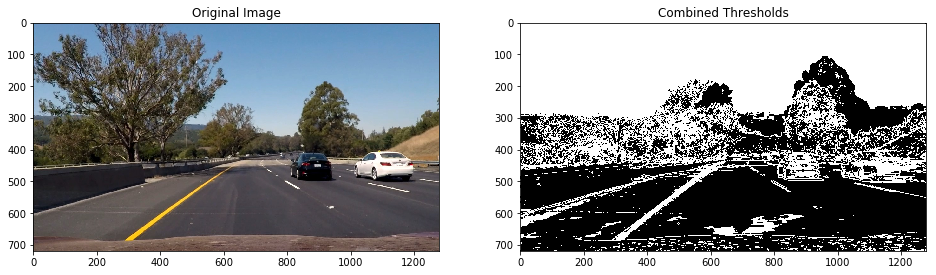

In [112]:
plt.figure(figsize=(16,16))

ax = plt.subplot(1,2,1)
ax.set_title('Original Image')
plt.imshow(test_img, cmap='gray')

ax = plt.subplot(1,2,2)
ax.set_title('Combined Thresholds')
plt.imshow(combine_thresholds_sample_video_img, cmap='gray')

plt.show()

For the combined binary threshold image, the following thresholds are logically OR-ed together:

1. Sobel x 
2. Sobel y 
3. Magnitude 
4. Saturation and Hue 

# Perspective Transform

The original video frame will be transformed to a top down view.  The top down view image will then be used to find the lane lines.  Afterwards, the reverse tranformation will be applied to the lane lines and drawn back onto the original image.

In [28]:
sample_video_img = imread('data/project_video/frame_0000100.jpg')
undistorted_sample_video_img = cal_undistort(sample_video_img, objpoints, imgpoints)
lane_line_sample_video_img = weighted_img(find_lane3(undistorted_sample_video_img), undistorted_sample_video_img)

In [29]:
def warp(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
        
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, Minv

The settings for src was set manually using the test image below.  The test image was selected because it was relatively straight.  The src settings were adjusted until the 4 points aligned with the tops and bottoms of the left and right lane lines in the warped image.

In [73]:
img_size = (lane_line_sample_video_img.shape[1], lane_line_sample_video_img.shape[0])

src = np.float32(
     [[(img_size[0] / 2) - 87, img_size[1] / 2 + 120],
     [((img_size[0] / 6) + 45), img_size[1]],
     [(img_size[0] * 5 / 6) + 75, img_size[1]],
     [(img_size[0] / 2 + 85), img_size[1] / 2 + 120]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])    

In [74]:
warped_sample_video_img, Minv = warp(lane_line_sample_video_img, src, dst)

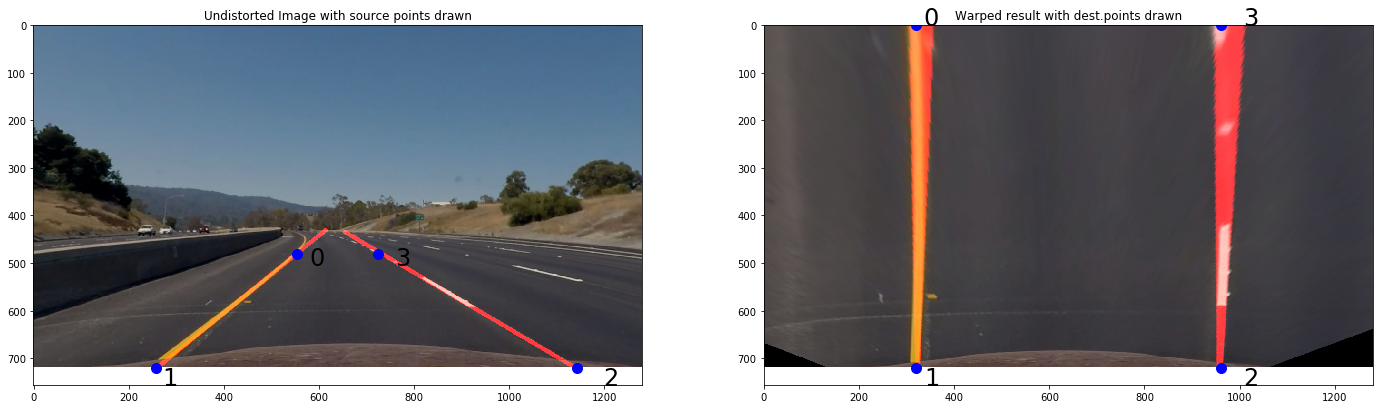

In [75]:
plt.figure(figsize=(24,32))

ax = plt.subplot(1,2,1)
ax.set_title('Undistorted Image with source points drawn')
plt.imshow(lane_line_sample_video_img)
for i in range(src.shape[0]):
    x,y = src[i]
    plt.plot(x,y, 'bo', markersize=10)
    plt.text(x * (1.05), y * (1.05) , i, fontsize=24)
    
ax = plt.subplot(1,2,2)
ax.set_title('Warped result with dest.points drawn')
plt.imshow(warped_sample_video_img)
for i in range(dst.shape[0]):
    x,y = dst[i]
    plt.plot(x,y, 'bo', markersize=10)
    plt.text(x * (1.05), y * (1.05) , i, fontsize=24)

plt.show()

In [188]:
def apply_img_pipeline(undistorted_img, objpoints, imgpoints):
    img_size = (undistorted_img.shape[1], undistorted_img.shape[0])

    src = np.float32(
         [[(img_size[0] / 2) - 87, img_size[1] / 2 + 120],
         [((img_size[0] / 6) + 45), img_size[1]],
         [(img_size[0] * 5 / 6) + 75, img_size[1]],
         [(img_size[0] / 2 + 85), img_size[1] / 2 + 120]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])    
    
    warped_img, Minv = warp(undistorted_img, src, dst)

    abs_sobel_thresh_x_img = abs_sobel_thresh(warped_img, orient='x', thresh_min=20, thresh_max=100)
    abs_sobel_thresh_y_img = abs_sobel_thresh(warped_img, orient='y', thresh_min=20, thresh_max=100)
    mag_thresh_img = mag_thresh(warped_img, mag_thresh=(30, 100))
    SH_threshold_img = make_SH_threshold_img(warped_img, S_thresh = (90, 255), H_thresh = (15, 100))
    
    combine_thresholds_img = combine_thresholds(abs_sobel_thresh_x_img, abs_sobel_thresh_y_img,
                                                mag_thresh_img, SH_threshold_img)  
    
    """
    plt.figure(figsize=(18,4))
    
    ax = plt.subplot(2,4,1)
    ax.set_title('undistorted')
    plt.imshow(undistorted_img)
    ax = plt.subplot(2,4,2)
    ax.set_title('warped')
    plt.imshow(warped_img, cmap='gray')
    
    ax = plt.subplot(2,4,3)
    ax.set_title('sobel x')
    plt.imshow(abs_sobel_thresh_x_img, cmap='gray')  
    ax = plt.subplot(2,4,4)
    ax.set_title('sobel y')
    plt.imshow(abs_sobel_thresh_y_img, cmap='gray')    
    ax = plt.subplot(2,4,5)
    ax.set_title('mag thresh')
    plt.imshow(mag_thresh_img, cmap='gray')  
    ax = plt.subplot(2,4,6)
    ax.set_title('SH thresh')
    plt.imshow(SH_threshold_img, cmap='gray')  
    
    ax = plt.subplot(2,4,7)
    ax.set_title('combine thresholds')
    plt.imshow(combine_thresholds_img, cmap='gray')
    plt.show()  
    """

    return combine_thresholds_img, Minv

# Lane Fitting

In [127]:
def get_basic_lane_lines(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
         [[(img_size[0] / 2) - 87, img_size[1] / 2 + 120],
         [((img_size[0] / 6) + 45), img_size[1]],
         [(img_size[0] * 5 / 6) + 75, img_size[1]],
         [(img_size[0] / 2 + 85), img_size[1] / 2 + 120]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])        
    
    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    
    undistorted_lane_lines = find_lane3(undistorted_img)
    undistorted_lane_lines[:,:,1] = undistorted_lane_lines[:,:,0]
    undistorted_lane_lines[:,:,2] = undistorted_lane_lines[:,:,0]
    
    return undistorted_lane_lines

If the basic lane line detection method fails (i.e. only one lane line was detected), it will fall back to searching for the lane lanes based on a sliding window.

In [128]:
def fit_initial_lanes(binary_warped, objpoints, imgpoints):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, nonzeroy, nonzerox, out_img

In [129]:
def fit_lanes(binary_warped, left_fit, right_fit, margin = 100):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create an output image to draw on and  visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)    

    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, nonzeroy, nonzerox, out_img

In [130]:
def plot_lanes(img, binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzeroy, nonzerox, out_img):
    # Generate x and y values for plotting
    plt.figure(figsize=(18,4))
    
    ax = plt.subplot(1,3,1)
    ax.set_title('Original Image')
    plt.imshow(img)
    
    ax = plt.subplot(1,3,2)
    ax.set_title('Binary Warped Image')
    plt.imshow(binary_warped, cmap='gray')
    
    ax = plt.subplot(1,3,3)
    ax.set_title('Lane Lines')
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    plt.show()

In [172]:
video_image_files = sorted(glob.glob('%s/project_video/*.jpg' % data_dir))
sample_video_imgs_np = read_imgs(video_image_files[100:110])
sample_video_imgs_arr = [sample_video_imgs_np[i] for i in range(sample_video_imgs_np.shape[0])]  

  0%|          | 0/10 [00:00<?, ?it/s]

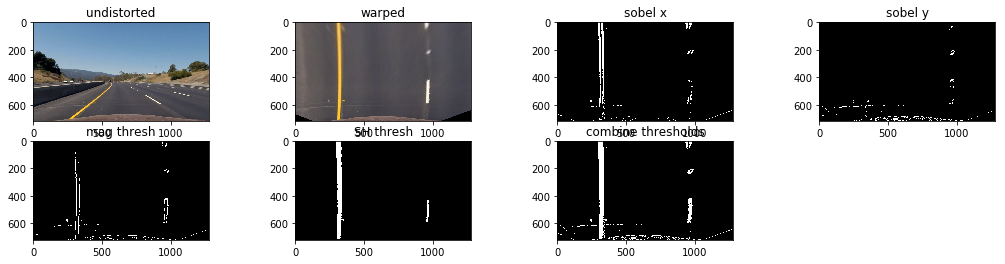

 10%|█         | 1/10 [00:02<00:21,  2.40s/it]

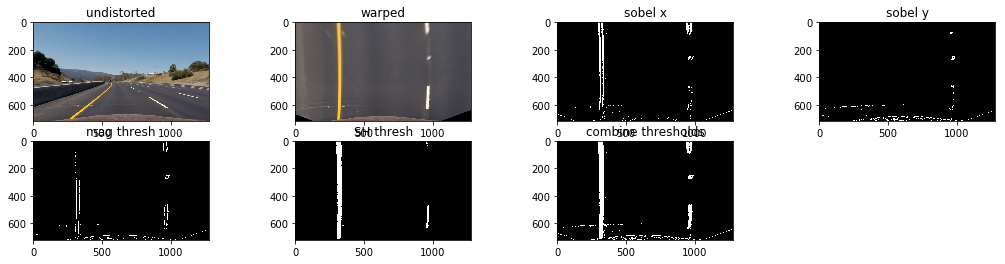

 20%|██        | 2/10 [00:04<00:19,  2.44s/it]

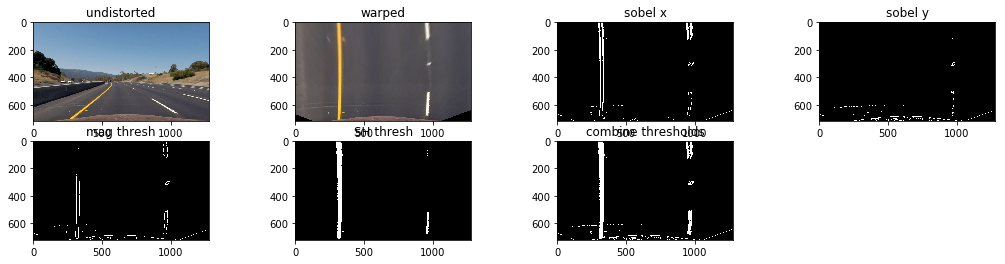

 30%|███       | 3/10 [00:07<00:17,  2.45s/it]

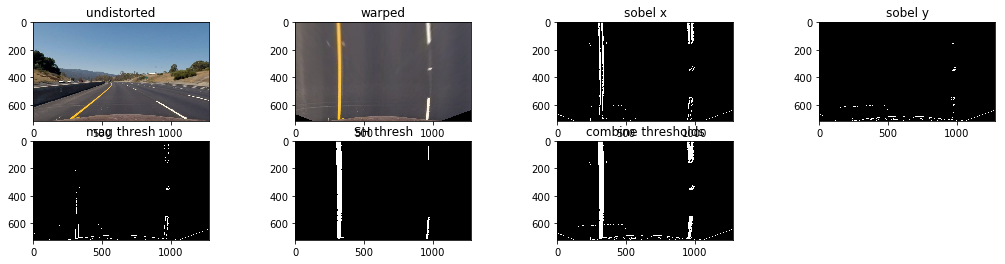

 40%|████      | 4/10 [00:09<00:14,  2.47s/it]

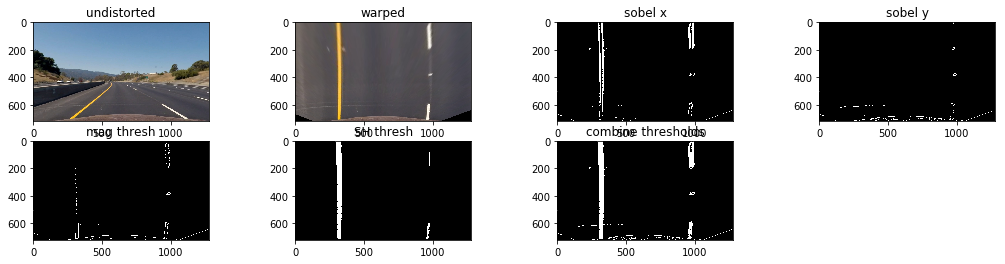

 50%|█████     | 5/10 [00:12<00:12,  2.41s/it]

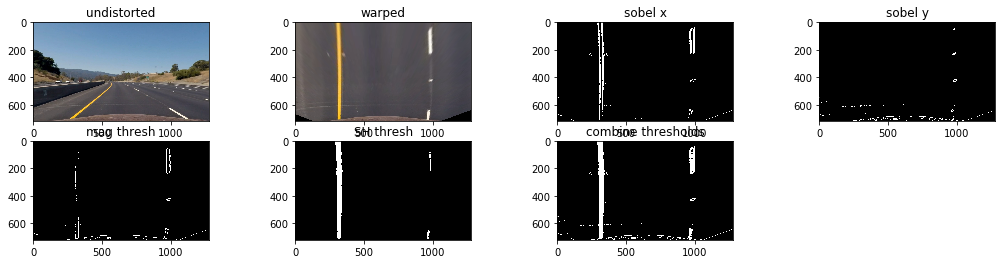

 60%|██████    | 6/10 [00:14<00:09,  2.39s/it]

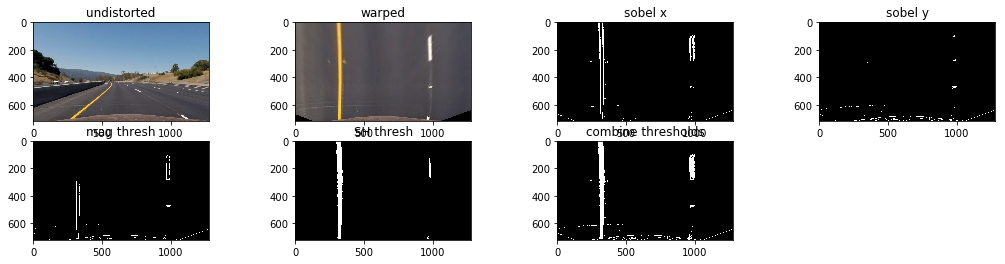

 70%|███████   | 7/10 [00:17<00:07,  2.48s/it]

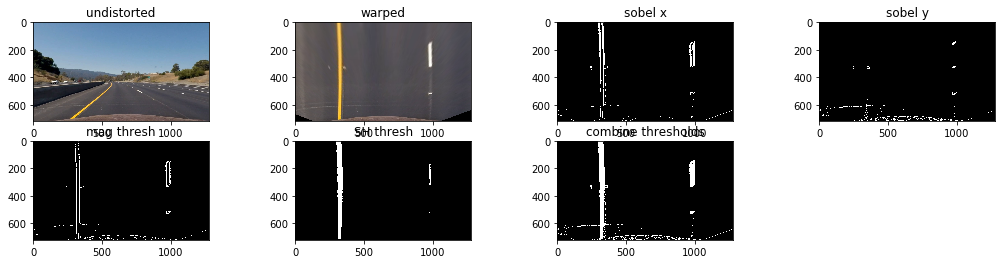

 80%|████████  | 8/10 [00:19<00:04,  2.47s/it]

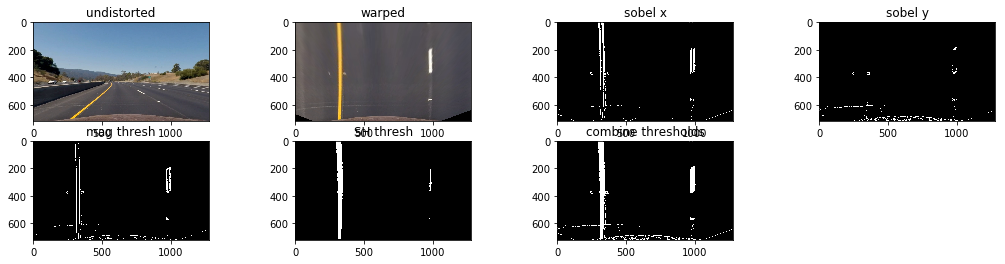

 90%|█████████ | 9/10 [00:22<00:02,  2.43s/it]

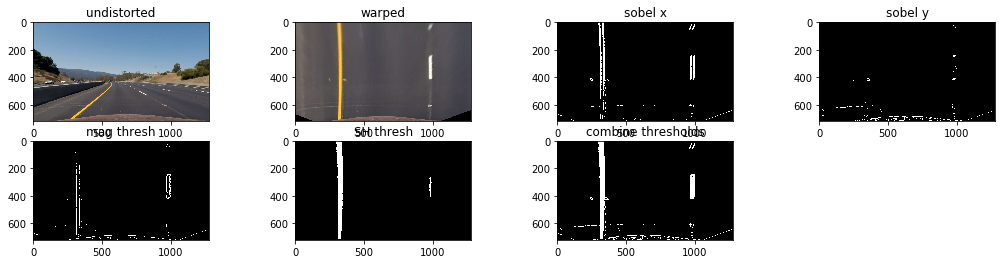

100%|██████████| 10/10 [00:24<00:00,  2.37s/it]


In [173]:
binary_warped_img_arr = []
Minv_arr = []

for sample_video_img in tqdm(sample_video_imgs_arr):       
    undistorted_img = cal_undistort(sample_video_img, objpoints, imgpoints)   
    binary_warped_img, Minv = apply_img_pipeline(undistorted_img, objpoints, imgpoints) 
    
    binary_warped_img_arr.append(binary_warped_img)
    Minv_arr.append(Minv)

### Fit Initial Lanes

This is using a sliding window method to find the lane lines.

In [174]:
left_fit, right_fit, left_lane_inds, \
right_lane_inds, nonzeroy, nonzerox, out_img = fit_initial_lanes(binary_warped_img_arr[0], objpoints, imgpoints)

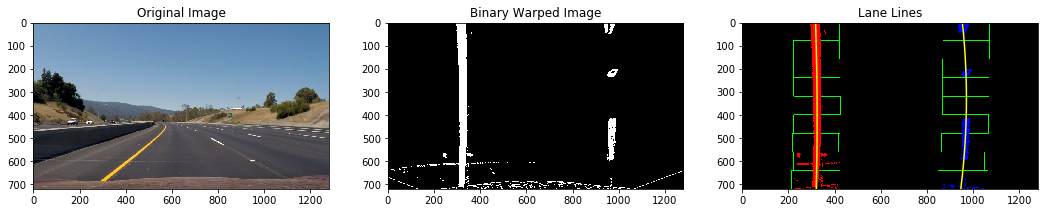

In [175]:
plot_lanes(sample_video_img, binary_warped_img_arr[0], left_fit, right_fit, left_lane_inds, right_lane_inds, nonzeroy, nonzerox, out_img)

### Fit Initial Lanes with Basic Lane Lines

For the first frame, we will use the basic lane line detection method from the initial Lane Line project.  This uses Canny filters and a Hough transform to fine the lane lines.  fit_initial_lanes() will then find the fits for the lane lines.  While this isn't the best method for find lanes, especially if the lanes are very curvy, it will give find_lanes() a good starting point in the following frames for searching nearby for the lane lines.  

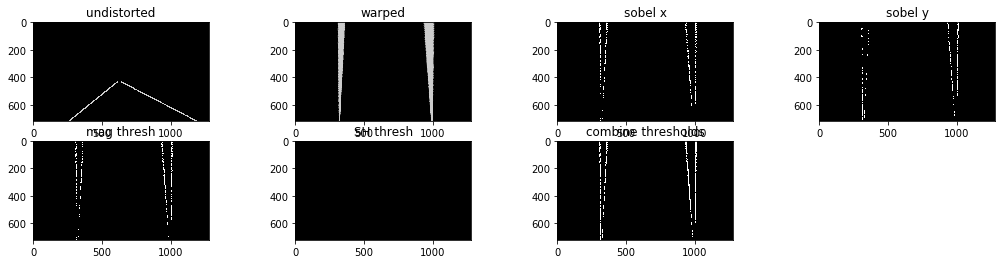

In [176]:
basic_lane_lines_img = get_basic_lane_lines(sample_video_img, objpoints, imgpoints)
warped_img, Minv = apply_img_pipeline(basic_lane_lines_img, objpoints, imgpoints) 
left_fit, right_fit, left_lane_inds, right_lane_inds, \
nonzeroy, nonzerox, out_img = fit_initial_lanes(warped_img, objpoints, imgpoints)

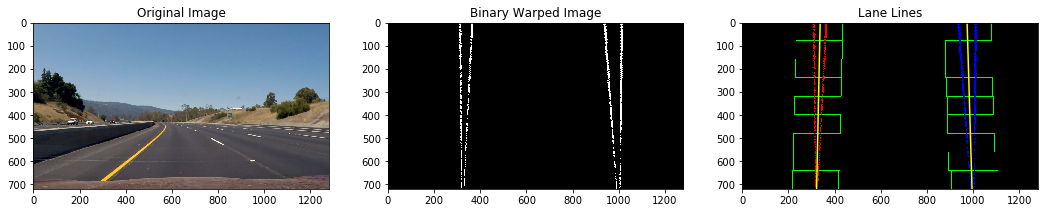

In [177]:
plot_lanes(sample_video_img, warped_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzeroy, 
           nonzerox, out_img)

### Fit Lanes

Based on the prior left and right fits (equations of the lane lines), find new lane lines.  Using the prior fits reduces the amount of the image that needs to be searched.  The current lane lines should be close by to where the prior lane lines were.  Problems occur when the prior fits are off.  Periodically, Fit Initial Lanes with Basic Lane Lines will be done to make sure that fit_lanes() has good prior fits.

In [178]:
left_fit, right_fit, left_lane_inds, right_lane_inds, \
nonzeroy, nonzerox, out_img = fit_lanes(binary_warped_img_arr[1], left_fit, right_fit)

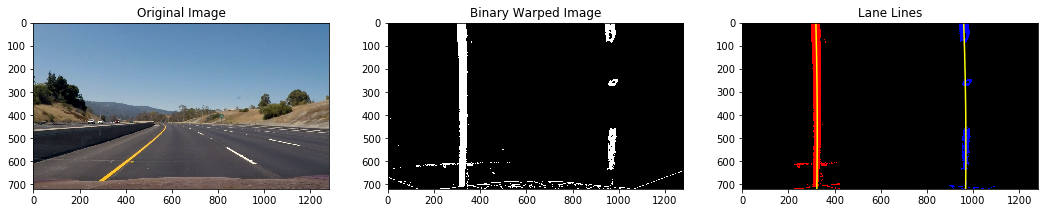

In [179]:
plot_lanes(sample_video_imgs_arr[1], binary_warped_img_arr[1], left_fit, right_fit, 
           left_lane_inds, right_lane_inds, nonzeroy,  nonzerox, out_img)

# Process Video Frames

In [89]:
class Line(object):
    def __init__(self, img_height, max_n_fits):
        self.img_height = img_height
        self.max_n_fits = max_n_fits
        
        self.fits = []
        
        self._y_vals = None
        
        self._last_mean_fit = None
        
    @property
    def mean_fit(self):
        if self.fits is None or len(self.fits) == 0:
            return None
        
        # Yah! Side effects! Cache the mean_fit value in last_mean_fit so you don't have to recalc.
        self._last_mean_fit = np.mean(self.fits, axis=0)
        
        return self._last_mean_fit
    
    @property
    def last_mean_fit(self):
        if self._last_mean_fit is None:
            self._last_mean_fit = self.mean_fit
            
        return self._last_mean_fit
    
    @property
    def y_vals(self):
        if self._y_vals is None:
            self._y_vals = np.linspace(0, self.img_height-1, num=self.img_height)
            
        return self._y_vals
    
    @property
    def x_vals(self):
        if self.mean_fit is None:
            return None
        
        return self.mean_fit[0] * self.y_vals**2 + self.mean_fit[1] * self.y_vals + self.mean_fit[2]
    
    @property
    def bottom_x(self):
        if self.mean_fit is None:
            return None
        
        return self.mean_fit[0] * self.img_height**2 + self.mean_fit[1] * self.img_height + self.mean_fit[2]
          
    @property
    def radius_of_curvature(self):
        """
        radius of curvature of the line in meters
        """
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension    

        fit = np.polyfit(self.y_vals*ym_per_pix, self.x_vals*xm_per_pix, 2)

        # Calculate the new radii of curvature
        radius_of_curvature = ((1 + (2*fit[0]*self.img_height*ym_per_pix + 
                                     fit[1])**2)**1.5) / np.absolute(2*fit[0])

        return radius_of_curvature 
    
    def add_fit(self, fit):
        self.fits.append(fit)
        
        if len(self.fits) > self.max_n_fits:
            self.fits = self.fits[-self.max_n_fits:]

In [90]:
def calc_lane_width(img_height, left_fit, right_fit):
    xm_per_pix = 3.7/700
    
    left_bottom_x = left_fit[0] * img_height**2 + left_fit[1] * img_height + left_fit[2]
    right_bottom_x = right_fit[0] * img_height**2 + right_fit[1] * img_height + right_fit[2]
    lane_width = (right_bottom_x - left_bottom_x) * xm_per_pix
    
    return lane_width

In [91]:
def draw_lanes_and_annotations(image, warped, Minv, ploty, left_fitx, right_fitx,
                                  curverad, offset, lane_width, frame_id=0):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))  
    
    # Combine the result with the original image
    #result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    output_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    frame_id_txt = 'Frame #%d' % frame_id
    curvature_txt = 'Curvature: %.2f' % curverad
    offset_txt = 'Offset: %.2f' % offset
    lane_width_txt = 'Lane Width: %.2f' % lane_width
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_color = (12, 12, 12)
    cv2.putText(output_img, frame_id_txt, (10,60), font, 2, text_color,2,cv2.LINE_AA)
    cv2.putText(output_img, curvature_txt, (10,120), font, 2, text_color,2,cv2.LINE_AA)
    cv2.putText(output_img, offset_txt, (10,180), font, 2, text_color,2,cv2.LINE_AA)
    cv2.putText(output_img, lane_width_txt, (10,240), font, 2, text_color,2,cv2.LINE_AA)

    return output_img

In [186]:
def make_lane_line_frames(img_files, output_dir, objpoints, imgpoints,
                          window_width = 50, window_height = 80, margin = 100, 
                          max_n_fits=10, reinit_cnt=40, start_idx=0, min_lane_width=None, max_lane_width=None):
    os.makedirs(output_dir, exist_ok=True)
    
    frame_files = []
    curvatures = []
    
    img_shape = imread(img_files[0]).shape
    img_height = img_shape[0]
    img_width = img_shape[1]
    
    left_line = Line(img_height, max_n_fits)
    right_line = Line(img_height, max_n_fits)
    ploty = left_line.y_vals

    init_fit_lanes = True
    xm_per_pix = 3.7/700
    offset = 0.0
    
    for i, img_file in enumerate(tqdm(img_files)):
        img = imread(img_file)
        
        if init_fit_lanes:
            """
            try:
                basic_lane_lines_img = get_basic_lane_lines(img, objpoints, imgpoints)
                warped, Minv = apply_img_pipeline(basic_lane_lines_img, objpoints, imgpoints) 
                left_fit, right_fit, _, _, _, _, _ = fit_initial_lanes(warped, objpoints, imgpoints)
                
                lane_width = calc_lane_width(img_height, left_fit, right_fit)
                if ((min_lane_width is not None and lane_width < min_lane_width) or 
                    (max_lane_width is not None and lane_width > max_lane_width)):
                    # If basic lane lines produces an invalid lane_width, revert back to fit_initial_lanes.
                    # (For curvy roads in Harder Challenge video.)
                    print("###falling back to fit_initial_lanes")
                    undistorted_img = cal_undistort(img, objpoints, imgpoints) 
                    warped, Minv = apply_img_pipeline(undistorted_img, objpoints, imgpoints) 
                    left_fit, right_fit, _, _, _, _, _ = fit_initial_lanes(warped, objpoints, imgpoints)
            except:
                undistorted_img = cal_undistort(img, objpoints, imgpoints) 
                warped, Minv = apply_img_pipeline(undistorted_img, objpoints, imgpoints) 
                left_fit, right_fit, _, _, _, _, _ = fit_initial_lanes(warped, objpoints, imgpoints)
            """
            undistorted_img = cal_undistort(img, objpoints, imgpoints) 
            warped, Minv = apply_img_pipeline(undistorted_img, objpoints, imgpoints) 
            left_fit, right_fit, _, _, _, _, _ = fit_initial_lanes(warped, objpoints, imgpoints)
                
            init_fit_lanes = False
        else:
            undistorted_img = cal_undistort(img, objpoints, imgpoints) 
            warped, Minv = apply_img_pipeline(undistorted_img, objpoints, imgpoints) 
            left_fit, right_fit, _, _, _, _, _ = fit_lanes(warped, left_line.last_mean_fit, 
                                                           right_line.last_mean_fit, margin = margin)
                
        left_line.add_fit(left_fit)
        right_line.add_fit(right_fit)

        frame_idx = i+start_idx

        offset = (img.shape[1]/2.0)-(left_line.bottom_x+right_line.bottom_x)/2.0
        
        lane_width = (right_line.bottom_x - left_line.bottom_x) * xm_per_pix

        if ((min_lane_width is not None and lane_width < min_lane_width) or 
            (max_lane_width is not None and lane_width > max_lane_width)):
            # the width of the lane seems too wide. reinit finding the lanes
            init_fit_lanes = True
        
        curverad = np.min([left_line.radius_of_curvature, right_line.radius_of_curvature])
        curvatures.append(curverad)
            
        road_with_lanes = draw_lanes_and_annotations(img, warped, Minv, ploty, 
                                                     left_line.x_vals, right_line.x_vals, 
                                                     curverad, offset, lane_width, frame_idx)
        
        frame_file = "%s/frame_%s.jpg" % (output_dir, pad_zeros(frame_idx))
        imsave(frame_file, road_with_lanes)
        
        frame_files.append(frame_file)
        
        if i % reinit_cnt == 0:
            # do an init after 10 times the number of cached fits
            init_fit_lanes = True 

    return frame_files, curvatures

In [93]:
def make_video(img_dir, outfile):
    file_list = sorted(glob.glob('%s/*.jpg' % img_dir))
    img_clips = []
    for file in tqdm(file_list):
        img_clips.append(ImageClip(file).set_duration(0.1)) 
    
    video = concatenate_videoclips(img_clips, method='compose')
    video.write_videofile(outfile, fps=24)

In [94]:
def plot_curvature_histogram(curvatures, num_bins = 20):
    n, bins, patches = plt.hist(curvatures, num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel('Radius of Curvature (meters)')
    plt.ylabel('Frequency')
    plt.title('Radius of Curvature Histogram')
    plt.show()

## Project Video

### Extract Frames 

In [103]:
video = 'project_video.mp4'
output_dir = '%s/project_video' % data_dir
extract_video_imgs(video, output_dir)

100%|██████████| 1259/1259 [01:00<00:00, 20.73it/s]


### Make Lane Line Images

In [104]:
lane_line_dir = '%s/lane_lines' % data_dir

In [ ]:
video_image_files = sorted(glob.glob('%s/*.jpg' % output_dir))

frame_files, curvatures = make_lane_line_frames(video_image_files, lane_line_dir, objpoints, imgpoints,
                                                max_n_fits=8, reinit_cnt=32, start_idx=0,
                                                min_lane_width=3.0, max_lane_width=3.8)

 11%|█         | 141/1259 [03:30<30:17,  1.63s/it]

In [ ]:
plot_curvature_histogram(curvatures, num_bins = 50)

In [ ]:
np.mean(curvatures)

In [ ]:
make_video(lane_line_dir, '%s/lane_lines.mp4' % data_dir)

## Challenge Video

### Extract Frames 

In [ ]:
video = 'challenge_video.mp4'
output_dir = '%s/challenge_video' % data_dir
extract_video_imgs(video, output_dir)

### Make Lane Line Images

In [ ]:
lane_line_dir = '%s/lane_lines_challenge_video' % data_dir

In [ ]:
video_image_files = sorted(glob.glob('%s/*.jpg' % output_dir))

frame_files, curvatures = make_lane_line_frames(video_image_files, lane_line_dir, objpoints, imgpoints,
                                                max_n_fits=12, reinit_cnt=48, start_idx=0,
                                                min_lane_width=2.6, max_lane_width=3.5)